# Analysis Processed Slocum Glider-AD2CP Data: RU29 2021 Mission 2

In [1]:
# Imports
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import netCDF4 as nc
import math
import datetime
import xarray as xr
import matplotlib.dates as mdates
import dask.array as da
from erddapy import ERDDAP
from netCDF4 import Dataset
import gsw
import cmocean.cm as cmo
import sys

## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
#sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/analysis/')
sys.path.insert(0,'../src/analysis/')
from analysis import gsw_rho, profile_mld, get_erddap_dataset, grid_glider_data, dist_from_lat_lon

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')

## Step 1: Load glider data

In [2]:
ds_id = 'ru29-20210908T1943-trajectory-raw-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'sci_water_temp', 'sci_water_cond','source_file', 'm_water_vx', 'm_water_vy', 'm_heading']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

gdf

# x=10
# plt.plot(gdf.depth[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])])

,depth,latitude,longitude,time,sci_water_temp,sci_water_cond,source_file,m_water_vx,m_water_vy,m_heading
0,0.0,18.172288,-64.968623,2021-09-08T19:43:16.84Z,0.0,0.0,ru29-2021-250-3-0-dbd(05900000),NaN,NaN,NaN
1,NaN,18.172288,-64.968623,2021-09-08T19:43:22.01Z,NaN,NaN,ru29-2021-250-3-0-dbd(05900000),0.0,0.0,1.77675
2,0.0,18.172288,-64.968623,2021-09-08T19:43:23.84Z,0.0,0.0,ru29-2021-250-3-0-dbd(05900000),NaN,NaN,NaN
3,NaN,18.172288,-64.968623,2021-09-08T19:44:26.30Z,NaN,NaN,ru29-2021-250-3-0-dbd(05900000),0.0,0.0,1.77675
4,NaN,18.172270,-64.968681,2021-09-08T19:44:52.37Z,NaN,NaN,ru29-2021-250-3-0-dbd(05900000),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1453164,NaN,NaN,NaN,2021-10-07T19:57:17.47Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN
1453165,NaN,NaN,NaN,2021-10-07T19:57:23.31Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN
1453166,NaN,NaN,NaN,2021-10-07T19:57:30.35Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN
1453167,NaN,NaN,NaN,2021-10-07T19:57:34.80Z,NaN,NaN,ru29-2021-279-2-0-dbd(06020000),NaN,NaN,NaN


## Step 2: Load processed AD2CP data

In [3]:
dz=10

path = "/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_2_AD2CP_NC/Processed_{}_meter_vertical_resolution/".format(dz)

files = np.sort(glob.glob(path+'*.csv'))

df = pd.concat(map(pd.read_csv, files))

df


,Unnamed: 0,inversion_u,inversion_v,inversion_depth,start_lon,start_lat,end_lon,end_lat,start_tm,end_tm,obs_per_bin
0,0,-0.140968,0.036835,5.0,-64.968623,18.172288,-64.969453,18.170708,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z,662.0
1,1,-0.141933,0.050153,15.0,-64.968623,18.172288,-64.969453,18.170708,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z,7561.0
2,2,-0.146303,0.052243,25.0,-64.968623,18.172288,-64.969453,18.170708,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z,10131.0
3,3,-0.153214,0.064736,35.0,-64.968623,18.172288,-64.969453,18.170708,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z,9796.0
4,4,-0.159064,0.078742,45.0,-64.968623,18.172288,-64.969453,18.170708,2021-09-08T19:43:16.84Z,2021-09-08T20:04:03.52Z,8707.0
...,...,...,...,...,...,...,...,...,...,...,...
76,76,-0.009726,0.065447,765.0,-63.274293,18.048022,-63.237385,18.024192,2021-09-21T19:04:01.31Z,2021-09-21T23:46:48.68Z,5288.0
77,77,-0.003630,0.071329,775.0,-63.274293,18.048022,-63.237385,18.024192,2021-09-21T19:04:01.31Z,2021-09-21T23:46:48.68Z,4845.0
78,78,0.000710,0.072544,785.0,-63.274293,18.048022,-63.237385,18.024192,2021-09-21T19:04:01.31Z,2021-09-21T23:46:48.68Z,4409.0
79,79,-0.000416,0.072528,795.0,-63.274293,18.048022,-63.237385,18.024192,2021-09-21T19:04:01.31Z,2021-09-21T23:46:48.68Z,3796.0


In [4]:
inversion_depth         = np.arange(np.min(df.inversion_depth),np.max(df.inversion_depth)+dz,dz)
inversion_time          = np.empty(len(files))
inversion_time[:]       = np.NaN
inversion_time          = inversion_time.astype(pd.Timestamp)
inversion_start_time    = np.empty(len(files))
inversion_start_time[:] = np.NaN
inversion_start_time    = inversion_time.astype(pd.Timestamp)
inversion_end_time      = np.empty(len(files))
inversion_end_time[:]   = np.NaN
inversion_end_time      = inversion_time.astype(pd.Timestamp)
inversion_lat           = np.empty(len(files))
inversion_lat[:]        = np.NaN
inversion_lon           = np.empty(len(files))
inversion_lon[:]        = np.NaN
inversion_start_lat     = np.empty(len(files))
inversion_start_lat[:]  = np.NaN
inversion_start_lon     = np.empty(len(files))
inversion_start_lon[:]  = np.NaN
inversion_end_lat       = np.empty(len(files))
inversion_end_lat[:]    = np.NaN
inversion_end_lon       = np.empty(len(files))
inversion_end_lon[:]    = np.NaN
u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN


## Loop through by file, load in each file
for x in np.arange(0,len(files)):
    
    df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(df.inversion_u.values)),x] = df.inversion_u.values
    v_grid[np.arange(0,len(df.inversion_v.values)),x] = df.inversion_v.values
    
    inversion_start_time[x] = pd.to_datetime(df.start_tm[0]).tz_localize(None)
    inversion_end_time[x] = pd.to_datetime(df.end_tm[0]).tz_localize(None)
    mid_time = inversion_end_time[x]-inversion_start_time[x]
    
    inversion_time[x] = inversion_start_time[x]+mid_time

    inversion_start_lat[x] = df.start_lat[0]
    inversion_start_lon[x] = df.start_lon[0]
    inversion_end_lat[x]   = df.end_lat[0]
    inversion_end_lon[x]   = df.end_lon[0]
    ## Lat/lon mid point
    inversion_lat[x]   = (df.start_lat[0]+df.end_lat[0])/2
    inversion_lon[x]   = (df.start_lon[0]+df.end_lon[0])/2


    
## Now stuff into an organized xarray dataset    
ds = xr.Dataset(
    data_vars=dict(
        u_grid     = (["depth", "time"], u_grid),
        v_grid     = (["depth", "time"], v_grid),
        latitude   = (["time"], inversion_lat),
        longitude  = (["time"], inversion_lon),
        start_lat  = (["time"], inversion_start_lat),
        start_lon  = (["time"], inversion_start_lon),
        end_lat    = (["time"], inversion_end_lat),
        end_lon    = (["time"], inversion_end_lon),
        start_time = (["time"], inversion_start_time),
        end_time   = (["time"], inversion_end_time)
    ),
    coords=dict(
        time  = inversion_time,
        depth = inversion_depth
    ),
    attrs=dict(description="Master/combined RU29 2021 Mission 2 AD2CP least-squares inversion velocity profile dataset"),
)

## Sort by time because files may not have in read in chronological order
ds = ds.sortby(ds.time)
ds

<xarray.Dataset>
Dimensions:     (depth: 102, time: 219)
Coordinates:
  * time        (time) datetime64[ns] 2021-09-08T20:04:03.520000 ... 2021-10-...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 995.0 1.005e+03 1.015e+03
Data variables:
    u_grid      (depth, time) float64 -0.141 0.007458 -0.04472 ... nan nan nan
    v_grid      (depth, time) float64 0.03683 0.05545 0.03476 ... nan nan nan
    latitude    (time) float64 18.17 18.17 18.16 18.14 ... 18.15 18.16 18.16
    longitude   (time) float64 -64.97 -64.97 -64.97 ... -64.81 -64.81 -64.81
    start_lat   (time) float64 18.17 18.17 18.17 18.15 ... 18.15 18.16 18.16
    start_lon   (time) float64 -64.97 -64.97 -64.97 ... -64.81 -64.81 -64.81
    end_lat     (time) float64 18.17 18.17 18.15 18.12 ... 18.16 18.16 18.16
    end_lon     (time) float64 -64.97 -64.97 -64.97 ... -64.81 -64.81 -64.81
    start_time  (time) datetime64[ns] 2021-09-08T19:43:16.840000 ... 2021-10-...
    end_time    (time) datetime64[ns] 2021-09-08T20:04:03.520000 ... 2021-10-...
Attributes:
    description:  Master/combined RU29 2021 Mission 2 AD2CP least-squares inv...

/tmp/ipykernel_2766/304361943.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ds.time,ds.depth,ds.u_grid,cmap='RdBu',vmin=-0.3,vmax=0.3)


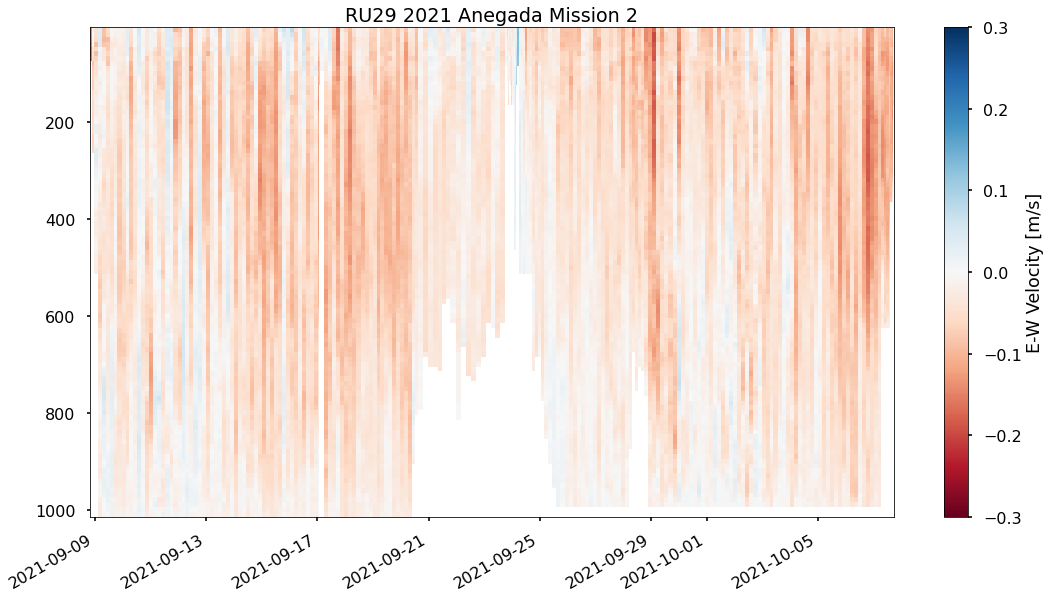

In [5]:
plt.figure(figsize=(18,10))
plt.pcolormesh(ds.time,ds.depth,ds.u_grid,cmap='RdBu',vmin=-0.3,vmax=0.3)
plt.gca().invert_yaxis()
plt.colorbar(label='E-W Velocity [m/s]')
plt.title('RU29 2021 Anegada Mission 2')
plt.gcf().autofmt_xdate()

/tmp/ipykernel_2766/3646313232.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ds.time,ds.depth,ds.v_grid,cmap='RdBu',vmin=-0.3,vmax=0.3)


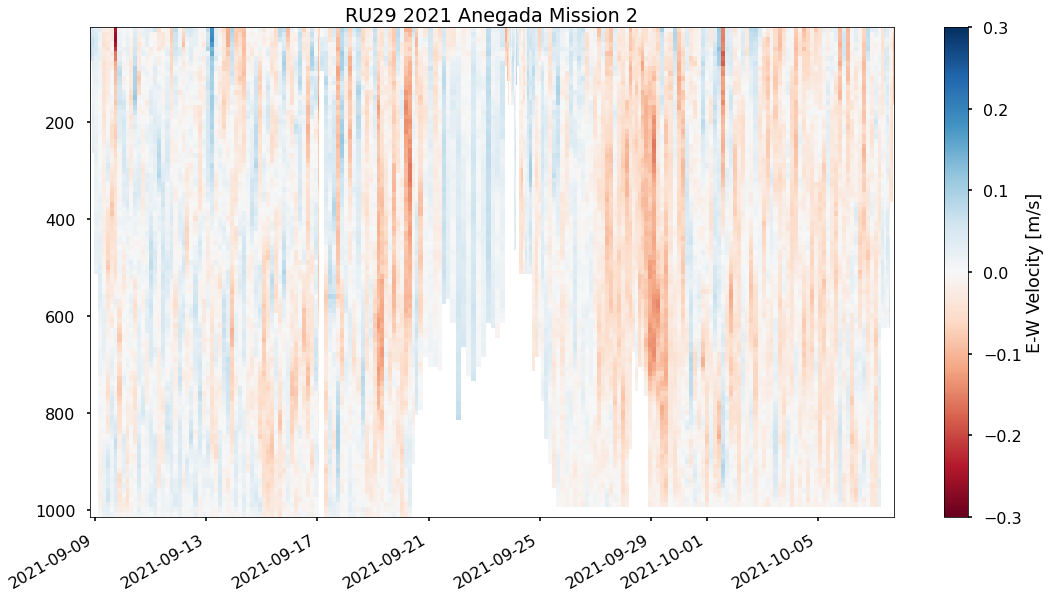

In [6]:
plt.figure(figsize=(18,10))
plt.pcolormesh(ds.time,ds.depth,ds.v_grid,cmap='RdBu',vmin=-0.3,vmax=0.3)
plt.gca().invert_yaxis()
plt.colorbar(label='E-W Velocity [m/s]')
plt.title('RU29 2021 Anegada Mission 2')
plt.gcf().autofmt_xdate()

## Anegada Subset

In [7]:
#subset_ds = ds.sel(time=slice("2021-09-14 00:00:00","2021-09-21 11:00:00"))

subset_ds = ds.sel(time=slice("2021-09-14 00:00:00","2021-09-18 11:00:00"))

In [8]:
# # grab bathymetry data for a map
# import cartopy.crs as ccrs
# lat_lims = [17.5, 19]
# lon_lims = [-65, -63]

# # grab some bathymetry
# url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'

# etopo1 = xr.open_dataset(url).sel(lat = slice(lat_lims[0], lat_lims[1]), lon = slice(lon_lims[0], lon_lims[1] ))

# fig = plt.figure(figsize=(15,20))
# ax = plt.subplot( projection= ccrs.Mercator())

# ## Good but too smooth
# #dpth_contours = np.arange(-8500, 1, 500)
# dpth_contours = np.append(np.arange(-5000, -2000, 500), np.arange(-2000, 1, 1000)) 

# plt.plot(subset_ds.longitude, subset_ds.latitude,linewidth=1, transform=ccrs.PlateCarree(),color='black')
# #plt.plot(gdf_sect.longitude.values, gdf_sect.latitude.values,linewidth=1, transform=ccrs.PlateCarree(),color='red')


# plt.contourf(etopo1.lon, etopo1.lat, etopo1.topo, dpth_contours, transform=ccrs.PlateCarree(), cmap='Blues_r', zorder=0,extend='both')
# #plt.colorbar(label='Depth [m]',pad=0.03, fraction=0.055)
# ax.coastlines()

# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color='black',linewidth=0.5)
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlabel_style = {'size': 12}
# gl.ylabel_style = {'size': 12}

# #plt.savefig('/Users/joegradone/Desktop/RU29_2021_Anegada_Map.png',dpi=300,facecolor='white')

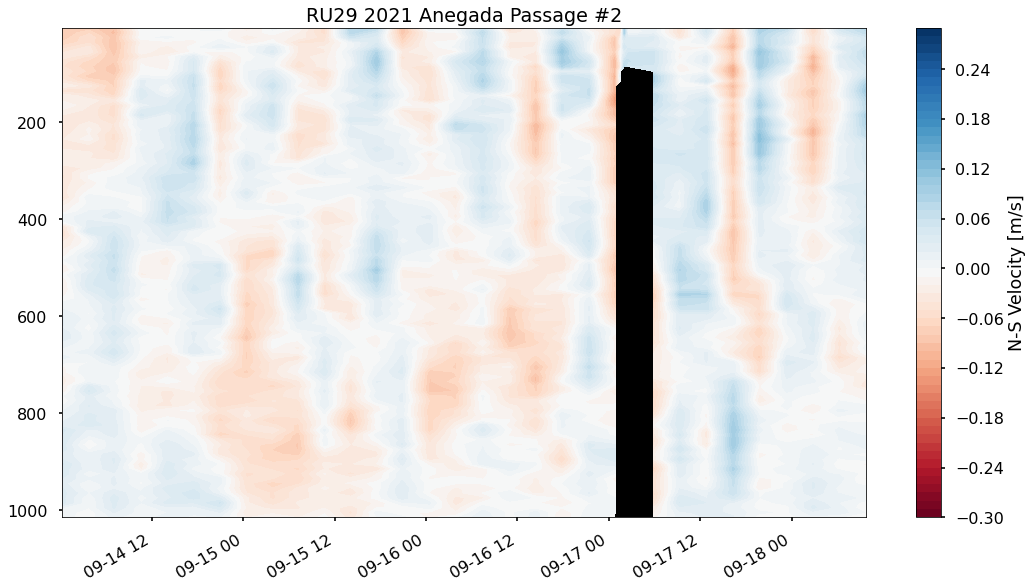

In [9]:
plt.figure(figsize=(18,10))
#plt.pcolormesh(subset_ds.time,subset_ds.depth,subset_ds.v_grid,cmap='RdBu',vmin=-0.3,vmax=0.3)
plt.gca().set_facecolor("black")

plt.contourf(subset_ds.time,subset_ds.depth,subset_ds.v_grid,cmap='RdBu',levels=np.arange(-0.3,0.3,0.01))
plt.gca().invert_yaxis()
plt.colorbar(label='N-S Velocity [m/s]')
plt.title('RU29 2021 Anegada Passage #2')
plt.gcf().autofmt_xdate()

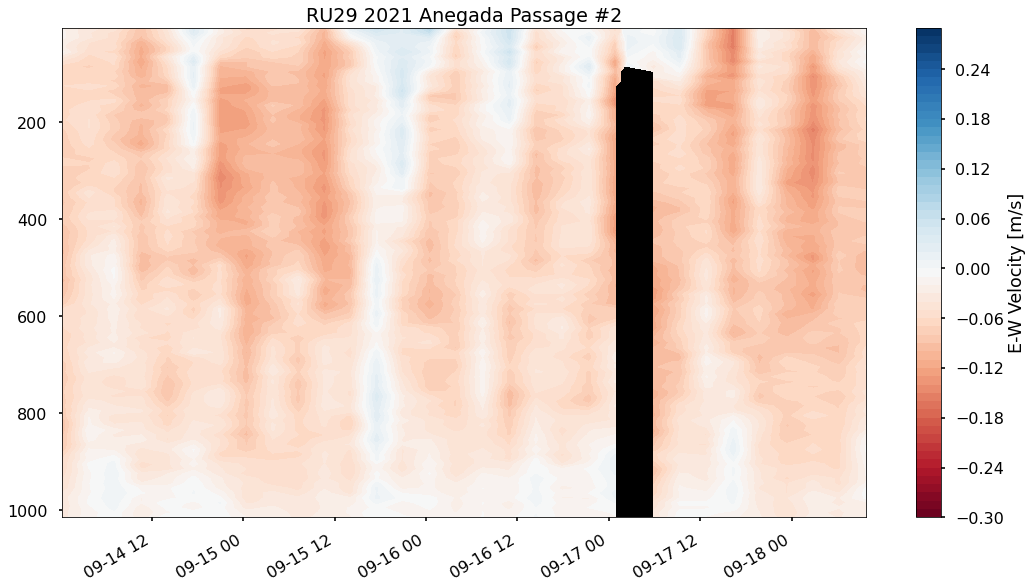

In [10]:
plt.figure(figsize=(18,10))
#plt.pcolormesh(subset_ds.time,subset_ds.depth,subset_ds.u_grid,cmap='RdBu',vmin=-0.3,vmax=0.3)
plt.contourf(subset_ds.time,subset_ds.depth,subset_ds.u_grid,cmap='RdBu',levels=np.arange(-0.3,0.3,0.01))
plt.gca().set_facecolor("black")

plt.gca().invert_yaxis()
plt.colorbar(label='E-W Velocity [m/s]')
plt.title('RU29 2021 Anegada Passage #2')
plt.gcf().autofmt_xdate()

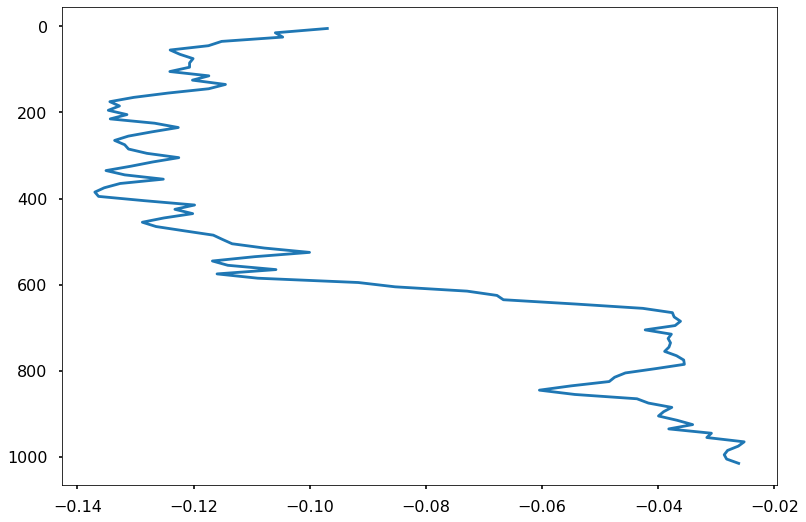

In [11]:
plt.plot(subset_ds.u_grid[:,10],subset_ds.depth)
plt.gca().invert_yaxis()

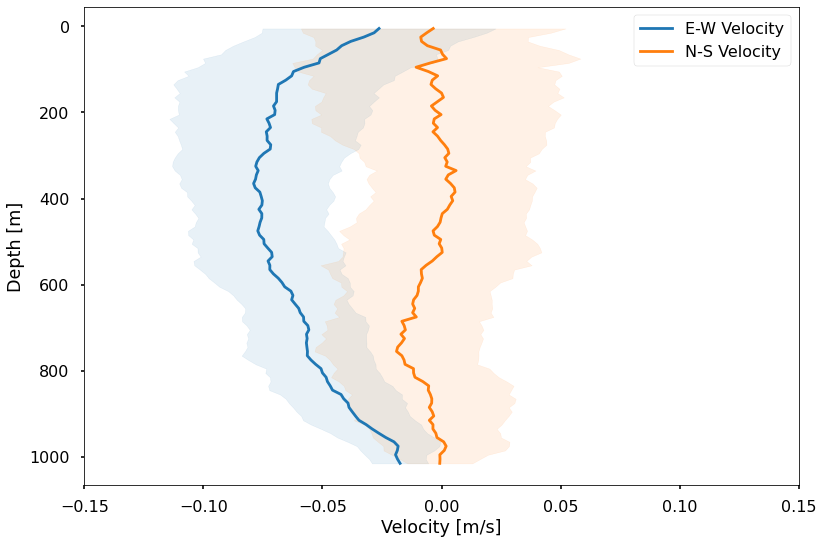

In [12]:
mean_vel_u = np.nanmean(subset_ds.u_grid,axis=1)
std_u = np.nanstd(subset_ds.u_grid,axis=1)

mean_vel_v = np.nanmean(subset_ds.v_grid,axis=1)
std_v = np.nanstd(subset_ds.v_grid,axis=1)


plt.plot(mean_vel_u, subset_ds.depth, color='tab:blue', label='E-W Velocity')
plt.fill_betweenx(subset_ds.depth, mean_vel_u, mean_vel_u+std_u, color='tab:blue', alpha=0.1)
plt.fill_betweenx(subset_ds.depth, mean_vel_u, mean_vel_u-std_u, color='tab:blue', alpha=0.1)


plt.plot(mean_vel_v, subset_ds.depth, color='tab:orange', label='N-S Velocity')
plt.fill_betweenx(subset_ds.depth, mean_vel_v, mean_vel_v+std_v, color='tab:orange', alpha=0.1)
plt.fill_betweenx(subset_ds.depth, mean_vel_v, mean_vel_v-std_v, color='tab:orange', alpha=0.1)


plt.gca().invert_yaxis()
plt.xlabel('Velocity [m/s]')
plt.ylabel('Depth [m]')
plt.xlim(-0.15,0.15)
plt.legend()

## What do "transport" look like through this section?

### Need to do calculation with distance PER segment!

In [13]:
segment_distances = np.empty(len(subset_ds.time))
segment_distances[:] = np.NaN

for x in np.arange(0,len(subset_ds.time)):
    segment_distances[x] = dist_from_lat_lon(subset_ds.start_lat[x],subset_ds.start_lon[x],subset_ds.end_lat[x],subset_ds.end_lon[x])
    

In [14]:
transport_u = np.empty(len(segment_distances))
transport_u[:] = np.NaN
transport_v = np.empty(len(segment_distances))
transport_v[:] = np.NaN

for x in np.arange(0,len(segment_distances)):
    transport_u[x] = (np.nansum(subset_ds.u_grid[:,x].values)*dz*segment_distances[x])/(10**6)
    transport_v[x] = (np.nansum(subset_ds.v_grid[:,x].values)*dz*segment_distances[x])/(10**6) 

In [15]:
np.nansum(transport_v)

-0.5862965169987635

In [16]:
np.nansum(transport_u)

-5.701500640962258

## Look at how much of the transport is above/below 200 meters for comparison with Johns et al. 1999

In [17]:
depth_ind = subset_ds.depth.values < 200

test = subset_ds.u_grid[depth_ind,:].values

transport_gridu_200 = np.empty(len(segment_distances))
transport_gridu_200[:] = np.NaN

for x in np.arange(0,len(segment_distances)):
    transport_gridu_200[x] = (np.nansum(test[:,x])*dz*segment_distances[x])/(10**6)


In [18]:
transport_gridu_200

array([-0.02911548, -0.03786342, -0.04118281, -0.06198742, -0.04419777,
        0.00716865, -0.05489837, -0.05625355, -0.04676344, -0.0464632 ,
       -0.06983645, -0.03273777, -0.0051191 ,  0.02261892, -0.01490016,
       -0.04496689, -0.01309422,  0.02151155, -0.04348652, -0.02429489,
       -0.00137492, -0.06385581, -0.0024656 , -0.00060503,  0.0001747 ,
       -0.02152408, -0.0078754 , -0.00130214, -0.1496772 , -0.02324699,
       -0.03804838, -0.06660837, -0.0370377 , -0.01927417])

## Testing rotating velocities by the orientation of the mouth of the Anegada Passage

In [19]:
along_vel = subset_ds.u_grid*np.cos(np.deg2rad(18))+subset_ds.v_grid*np.sin(np.deg2rad(18))
cross_vel = subset_ds.u_grid*np.sin(np.deg2rad(18))+subset_ds.v_grid*np.cos(np.deg2rad(18))

# ## Along glider/cross glider?
# along_vel = subset_ds.u_grid*np.cos(np.deg2rad(90))+subset_ds.v_grid*np.sin(np.deg2rad(90))
# cross_vel = subset_ds.u_grid*np.sin(np.deg2rad(90))+subset_ds.v_grid*np.cos(np.deg2rad(90))


In [20]:
transport_along = np.empty(len(segment_distances))
transport_along[:] = np.NaN
transport_cross = np.empty(len(segment_distances))
transport_cross[:] = np.NaN

for x in np.arange(0,len(segment_distances)):
    transport_along[x] = (np.nansum(along_vel[:,x].values)*dz*segment_distances[x])/(10**6)
    transport_cross[x] = (np.nansum(cross_vel[:,x].values)*dz*segment_distances[x])/(10**6) 


In [21]:
np.nansum(transport_cross)

-2.3194617144698193

In [22]:
np.nansum(transport_along)

-5.603624924743609

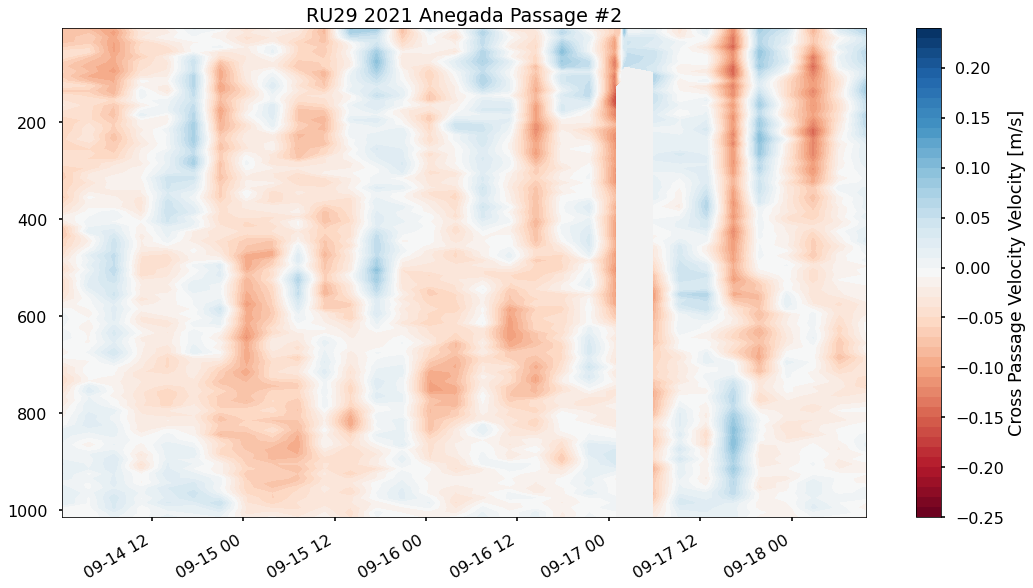

In [23]:
#plt.figure(figsize=(18,10))
#plt.pcolormesh(subset_ds.time,subset_ds.depth,cross_vel,cmap='RdBu',vmin=-0.3,vmax=0.3)
#ax = plt.contourf(subset_ds.time,subset_ds.depth,cross_vel,cmap='RdBu',levels=np.arange(-0.25,0.25,0.01))
#plt.gca().set_facecolor("grey")



fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
contour = ax.contourf(subset_ds.time,subset_ds.depth,cross_vel,cmap='RdBu',levels=np.arange(-0.25,0.25,0.01))
ax.patch.set_facecolor('grey')
ax.patch.set_alpha(0.1)
ax.invert_yaxis()
fig.colorbar(contour,label='Cross Passage Velocity Velocity [m/s]')
ax.set_title('RU29 2021 Anegada Passage #2')
fig.autofmt_xdate()

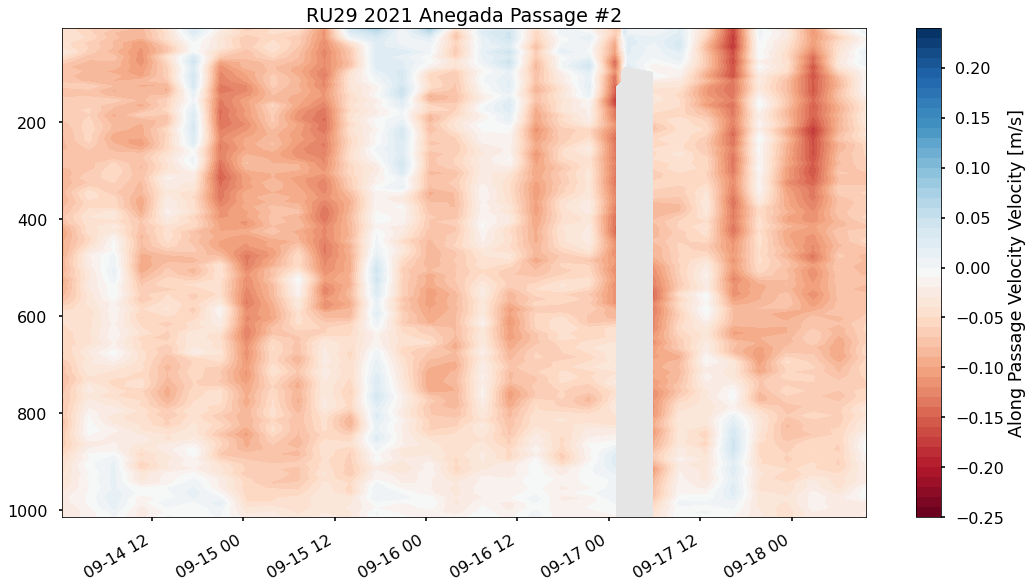

In [24]:
#plt.figure(figsize=(18,10))
#plt.pcolormesh(subset_ds.time,subset_ds.depth,cross_vel,cmap='RdBu',vmin=-0.3,vmax=0.3)
#ax = plt.contourf(subset_ds.time,subset_ds.depth,cross_vel,cmap='RdBu',levels=np.arange(-0.25,0.25,0.01))
#plt.gca().set_facecolor("grey")



fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
contour = ax.contourf(subset_ds.time,subset_ds.depth,along_vel,cmap='RdBu',levels=np.arange(-0.25,0.25,0.01))
ax.patch.set_facecolor('grey')
ax.patch.set_alpha(0.2)
ax.invert_yaxis()
fig.colorbar(contour,label='Along Passage Velocity Velocity [m/s]')
ax.set_title('RU29 2021 Anegada Passage #2')
fig.autofmt_xdate()

In [25]:
cum_dist = np.cumsum(segment_distances)/1000
len(cum_dist)

34

## Interpolate glider temperature, salinity, and density data onto same grid as transport data

In [26]:
sci_ds_id = 'ru29-20210908T1943-profile-sci-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'temperature', 'salinity','density']
sci_gdf = get_erddap_dataset(sci_ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
sci_gdf.columns = variables

## Edit time formatting for subsetting
glider_times = pd.to_datetime(sci_gdf.time.values).tz_localize(None)
sci_gdf.time = glider_times

sci_gdf

,depth,latitude,longitude,time,temperature,salinity,density
0,-0.04970,18.172249,-64.968765,2021-09-08 19:45:29.540,30.1678,34.781155,1021.50460
1,NaN,18.172250,-64.968767,2021-09-08 19:45:30.290,NaN,NaN,NaN
2,-0.01988,18.172250,-64.968769,2021-09-08 19:45:31.550,30.1697,34.782074,1021.50470
3,0.00994,18.172250,-64.968772,2021-09-08 19:45:33.570,30.1624,34.783863,1021.50867
4,0.00994,18.172250,-64.968775,2021-09-08 19:45:35.580,30.1636,34.782463,1021.50726
...,...,...,...,...,...,...,...
1401589,0.01988,18.164149,-64.814803,2021-10-07 17:22:08.740,29.5205,34.403038,1021.44170
1401590,0.08946,18.164149,-64.814801,2021-10-07 17:22:10.750,29.5221,34.403030,1021.44147
1401591,NaN,18.164148,-64.814800,2021-10-07 17:22:11.870,NaN,NaN,NaN
1401592,0.06958,18.164149,-64.814802,2021-10-07 17:22:12.770,29.5257,34.402367,1021.43970


In [27]:
## Pull out depth to interpolate onto
griddepth = ds.depth.values

## Pre-allocate
gridtemp = np.empty((len(griddepth),len(ds.time)))
gridtemp[:] = np.NaN
gridsalinity = np.empty((len(griddepth),len(ds.time)))
gridsalinity[:] = np.NaN
griddensity = np.empty((len(griddepth),len(ds.time)))
griddensity[:] = np.NaN


for x in np.arange(0,len(ds.time)):
    sci_gdf2 = sci_gdf.loc[(sci_gdf.time.values >= ds.start_time.values[x]) & (sci_gdf.time.values <= ds.end_time.values[x])]

    gridtemp[:,x]     = interp.griddata(sci_gdf2.depth.values,sci_gdf2.temperature.values,griddepth)
    gridsalinity[:,x] = interp.griddata(sci_gdf2.depth.values,sci_gdf2.salinity.values,griddepth)
    griddensity[:,x]  = interp.griddata(sci_gdf2.depth.values,sci_gdf2.density.values,griddepth)


## Transport per temperature range

In [28]:
transport_u_1 = np.empty(len(segment_distances))
transport_u_1[:] = np.NaN
transport_v_1 = np.empty(len(segment_distances))
transport_v_1[:] = np.NaN

transport_u_2 = np.empty(len(segment_distances))
transport_u_2[:] = np.NaN
transport_v_2 = np.empty(len(segment_distances))
transport_v_2[:] = np.NaN

transport_u_3 = np.empty(len(segment_distances))
transport_u_3[:] = np.NaN
transport_v_3 = np.empty(len(segment_distances))
transport_v_3[:] = np.NaN

transport_u_4 = np.empty(len(segment_distances))
transport_u_4[:] = np.NaN
transport_v_4 = np.empty(len(segment_distances))
transport_v_4[:] = np.NaN

transport_u_5 = np.empty(len(segment_distances))
transport_u_5[:] = np.NaN
transport_v_5 = np.empty(len(segment_distances))
transport_v_5[:] = np.NaN


for x in np.arange(0,len(segment_distances)):
    ## Find where temp fits criteria and only sum up transport there
    ind1 = np.where(gridtemp[:,x] < 7)[0]
    ## Only sum up transport for these indexes
    transport_u_1[x] = (np.nansum(subset_ds.u_grid[ind1,x].values)*dz*segment_distances[x])/(10**6)
    transport_v_1[x] = (np.nansum(subset_ds.v_grid[ind1,x].values)*dz*segment_distances[x])/(10**6) 
    
    ## Find where temp fits criteria and only sum up transport there
    ind2 = np.where((gridtemp[:,x] > 7) & (gridtemp[:,x] < 12))[0]
    ## Only sum up transport for these indexes
    transport_u_2[x] = (np.nansum(subset_ds.u_grid[ind2,x].values)*dz*segment_distances[x])/(10**6)
    transport_v_2[x] = (np.nansum(subset_ds.v_grid[ind2,x].values)*dz*segment_distances[x])/(10**6) 
    
    ## Find where temp fits criteria and only sum up transport there
    ind3 = np.where((gridtemp[:,x] > 12) & (gridtemp[:,x] < 17))[0]
    ## Only sum up transport for these indexes
    transport_u_3[x] = (np.nansum(subset_ds.u_grid[ind3,x].values)*dz*segment_distances[x])/(10**6)
    transport_v_3[x] = (np.nansum(subset_ds.v_grid[ind3,x].values)*dz*segment_distances[x])/(10**6) 
    
    ## Find where temp fits criteria and only sum up transport there
    ind4 = np.where((gridtemp[:,x] > 17) & (gridtemp[:,x] < 24))[0]
    ## Only sum up transport for these indexes
    transport_u_4[x] = (np.nansum(subset_ds.u_grid[ind4,x].values)*dz*segment_distances[x])/(10**6)
    transport_v_4[x] = (np.nansum(subset_ds.v_grid[ind4,x].values)*dz*segment_distances[x])/(10**6) 
    
    ## Find where temp fits criteria and only sum up transport there
    ind5 = np.where(gridtemp[:,x] > 24)[0]
    ## Only sum up transport for these indexes
    transport_u_5[x] = (np.nansum(subset_ds.u_grid[ind5,x].values)*dz*segment_distances[x])/(10**6)
    transport_v_5[x] = (np.nansum(subset_ds.v_grid[ind5,x].values)*dz*segment_distances[x])/(10**6) 
    


In [29]:
print('Transport <7 degrees C',np.round(np.nansum(transport_u_1),3),'Sv')

print('Transport between 7-12 degrees C',np.round(np.nansum(transport_u_2),3),'Sv')

print('Transport between 12-17 degrees C',np.round(np.nansum(transport_u_3),3),'Sv')

print('Transport between 17-24 degrees C',np.round(np.nansum(transport_u_4),3),'Sv')

print('Transport >24 degrees C',np.round(np.nansum(transport_u_5),3),'Sv')

Transport <7 degrees C -0.755 Sv
Transport between 7-12 degrees C -1.314 Sv
Transport between 12-17 degrees C -1.456 Sv
Transport between 17-24 degrees C -1.141 Sv
Transport >24 degrees C -0.668 Sv


In [30]:
np.nansum(transport_u_1)+ np.nansum(transport_u_2)+np.nansum(transport_u_3)+np.nansum(transport_u_4)+np.nansum(transport_u_5)


-5.333653154098658

## Transport of 18 C water

In [31]:
transport_u_18 = np.empty(len(segment_distances))
transport_u_18[:] = np.NaN
transport_v_18 = np.empty(len(segment_distances))
transport_v_18[:] = np.NaN

min_temp = 17
max_temp = 19
min_sal  = 36.25
max_sal  = 36.75

for x in np.arange(0,len(segment_distances)):
    ## Find where temp fits criteria and only sum up transport there
    ind1 = np.where((gridtemp[:,x] >= min_temp) & (gridtemp[:,x] <= max_temp) & (gridsalinity[:,x] >= min_sal) & (gridsalinity[:,x] <= max_sal))[0]
    ## Only sum up transport for these indexes
    transport_u_18[x] = (np.nansum(subset_ds.u_grid[ind1,x].values)*dz*segment_distances[x])/(10**6)
    transport_v_18[x] = (np.nansum(subset_ds.v_grid[ind1,x].values)*dz*segment_distances[x])/(10**6) 


In [32]:
np.nansum(transport_u_18)

-0.5072489809180116

## Plot 2021 Missions 1 and 2 together

In [33]:
dz=10
path = "/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_1_AD2CP_NC/Processed_{}_meter_vertical_resolution/".format(dz)
#path = "/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/RU_29/2021_Mission_1_Processed_Velocity_Profiles/"
files = np.sort(glob.glob(path+'*.csv'))
df = pd.concat(map(pd.read_csv, files))


inversion_depth         = np.arange(np.min(df.inversion_depth),np.max(df.inversion_depth)+dz,dz)
inversion_time          = np.empty(len(files))
inversion_time[:]       = np.NaN
inversion_time          = inversion_time.astype(pd.Timestamp)
inversion_start_time    = np.empty(len(files))
inversion_start_time[:] = np.NaN
inversion_start_time    = inversion_time.astype(pd.Timestamp)
inversion_end_time      = np.empty(len(files))
inversion_end_time[:]   = np.NaN
inversion_end_time      = inversion_time.astype(pd.Timestamp)
inversion_lat           = np.empty(len(files))
inversion_lat[:]        = np.NaN
inversion_lon           = np.empty(len(files))
inversion_lon[:]        = np.NaN
inversion_start_lat     = np.empty(len(files))
inversion_start_lat[:]  = np.NaN
inversion_start_lon     = np.empty(len(files))
inversion_start_lon[:]  = np.NaN
inversion_end_lat       = np.empty(len(files))
inversion_end_lat[:]    = np.NaN
inversion_end_lon       = np.empty(len(files))
inversion_end_lon[:]    = np.NaN
u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN


## Loop through by file, load in each file
for x in np.arange(0,len(files)):
    
    df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(df.inversion_u.values)),x] = df.inversion_u.values
    v_grid[np.arange(0,len(df.inversion_v.values)),x] = df.inversion_v.values
    
    inversion_start_time[x] = pd.to_datetime(df.start_tm[0]).tz_localize(None)
    inversion_end_time[x] = pd.to_datetime(df.end_tm[0]).tz_localize(None)
    mid_time = inversion_end_time[x]-inversion_start_time[x]
    
    inversion_time[x] = inversion_start_time[x]+mid_time

    inversion_start_lat[x] = df.start_lat[0]
    inversion_start_lon[x] = df.start_lon[0]
    inversion_end_lat[x]   = df.end_lat[0]
    inversion_end_lon[x]   = df.end_lon[0]
    ## Lat/lon mid point
    inversion_lat[x]   = (df.start_lat[0]+df.end_lat[0])/2
    inversion_lon[x]   = (df.start_lon[0]+df.end_lon[0])/2


    
## Now stuff into an organized xarray dataset    
ds_a = xr.Dataset(
    data_vars=dict(
        u_grid     = (["depth", "time"], u_grid),
        v_grid     = (["depth", "time"], v_grid),
        latitude   = (["time"], inversion_lat),
        longitude  = (["time"], inversion_lon),
        start_lat  = (["time"], inversion_start_lat),
        start_lon  = (["time"], inversion_start_lon),
        end_lat    = (["time"], inversion_end_lat),
        end_lon    = (["time"], inversion_end_lon),
        start_time = (["time"], inversion_start_time),
        end_time   = (["time"], inversion_end_time)
    ),
    coords=dict(
        time  = inversion_time,
        depth = inversion_depth
    ),
    attrs=dict(description="Master/combined RU29 2021 Mission 1 AD2CP least-squares inversion velocity profile dataset"),
)

## Sort by time because files may not have in read in chronological order
ds_a = ds_a.sortby(ds_a.time)
ds_a


<xarray.Dataset>
Dimensions:     (depth: 98, time: 113)
Coordinates:
  * time        (time) datetime64[ns] 2021-06-30T14:30:55 ... 2021-07-14T11:1...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 945.0 955.0 965.0 975.0
Data variables:
    u_grid      (depth, time) float64 -0.1183 -0.07372 -0.05783 ... nan nan nan
    v_grid      (depth, time) float64 -0.0172 0.04695 0.006812 ... nan nan nan
    latitude    (time) float64 18.17 18.17 18.16 18.15 ... 18.15 18.15 18.15
    longitude   (time) float64 -64.83 -64.83 -64.81 ... -63.81 -63.82 -63.83
    start_lat   (time) float64 18.17 18.17 18.16 18.15 ... 18.15 18.15 18.15
    start_lon   (time) float64 -64.83 -64.83 -64.82 ... -63.8 -63.82 -63.83
    end_lat     (time) float64 18.17 18.16 18.15 18.14 ... 18.15 18.15 18.14
    end_lon     (time) float64 -64.83 -64.82 -64.8 ... -63.82 -63.83 -63.83
    start_time  (time) datetime64[ns] 2021-06-30T13:43:52 ... 2021-07-14T10:2...
    end_time    (time) datetime64[ns] 2021-06-30T14:30:55 ... 2021-07-14T11:1...
Attributes:
    description:  Master/combined RU29 2021 Mission 1 AD2CP least-squares inv...

In [34]:
dz=10
path = "/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_2_AD2CP_NC/Processed_{}_meter_vertical_resolution/".format(dz)
files = np.sort(glob.glob(path+'*.csv'))
df = pd.concat(map(pd.read_csv, files))

inversion_depth         = np.arange(np.min(df.inversion_depth),np.max(df.inversion_depth)+dz,dz)
inversion_time          = np.empty(len(files))
inversion_time[:]       = np.NaN
inversion_time          = inversion_time.astype(pd.Timestamp)
inversion_start_time    = np.empty(len(files))
inversion_start_time[:] = np.NaN
inversion_start_time    = inversion_time.astype(pd.Timestamp)
inversion_end_time      = np.empty(len(files))
inversion_end_time[:]   = np.NaN
inversion_end_time      = inversion_time.astype(pd.Timestamp)
inversion_lat           = np.empty(len(files))
inversion_lat[:]        = np.NaN
inversion_lon           = np.empty(len(files))
inversion_lon[:]        = np.NaN
inversion_start_lat     = np.empty(len(files))
inversion_start_lat[:]  = np.NaN
inversion_start_lon     = np.empty(len(files))
inversion_start_lon[:]  = np.NaN
inversion_end_lat       = np.empty(len(files))
inversion_end_lat[:]    = np.NaN
inversion_end_lon       = np.empty(len(files))
inversion_end_lon[:]    = np.NaN
u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN


## Loop through by file, load in each file
for x in np.arange(0,len(files)):
    
    df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(df.inversion_u.values)),x] = df.inversion_u.values
    v_grid[np.arange(0,len(df.inversion_v.values)),x] = df.inversion_v.values
    
    inversion_start_time[x] = pd.to_datetime(df.start_tm[0]).tz_localize(None)
    inversion_end_time[x] = pd.to_datetime(df.end_tm[0]).tz_localize(None)
    mid_time = inversion_end_time[x]-inversion_start_time[x]
    
    inversion_time[x] = inversion_start_time[x]+mid_time

    inversion_start_lat[x] = df.start_lat[0]
    inversion_start_lon[x] = df.start_lon[0]
    inversion_end_lat[x]   = df.end_lat[0]
    inversion_end_lon[x]   = df.end_lon[0]
    ## Lat/lon mid point
    inversion_lat[x]   = (df.start_lat[0]+df.end_lat[0])/2
    inversion_lon[x]   = (df.start_lon[0]+df.end_lon[0])/2


    
## Now stuff into an organized xarray dataset    
ds_b = xr.Dataset(
    data_vars=dict(
        u_grid     = (["depth", "time"], u_grid),
        v_grid     = (["depth", "time"], v_grid),
        latitude   = (["time"], inversion_lat),
        longitude  = (["time"], inversion_lon),
        start_lat  = (["time"], inversion_start_lat),
        start_lon  = (["time"], inversion_start_lon),
        end_lat    = (["time"], inversion_end_lat),
        end_lon    = (["time"], inversion_end_lon),
        start_time = (["time"], inversion_start_time),
        end_time   = (["time"], inversion_end_time)
    ),
    coords=dict(
        time  = inversion_time,
        depth = inversion_depth
    ),
    attrs=dict(description="Master/combined RU29 2021 Mission 2 AD2CP least-squares inversion velocity profile dataset"),
)

## Sort by time because files may not have in read in chronological order
ds_b = ds_b.sortby(ds_b.time)
ds_b


<xarray.Dataset>
Dimensions:     (depth: 102, time: 219)
Coordinates:
  * time        (time) datetime64[ns] 2021-09-08T20:04:03.520000 ... 2021-10-...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 995.0 1.005e+03 1.015e+03
Data variables:
    u_grid      (depth, time) float64 -0.141 0.007458 -0.04472 ... nan nan nan
    v_grid      (depth, time) float64 0.03683 0.05545 0.03476 ... nan nan nan
    latitude    (time) float64 18.17 18.17 18.16 18.14 ... 18.15 18.16 18.16
    longitude   (time) float64 -64.97 -64.97 -64.97 ... -64.81 -64.81 -64.81
    start_lat   (time) float64 18.17 18.17 18.17 18.15 ... 18.15 18.16 18.16
    start_lon   (time) float64 -64.97 -64.97 -64.97 ... -64.81 -64.81 -64.81
    end_lat     (time) float64 18.17 18.17 18.15 18.12 ... 18.16 18.16 18.16
    end_lon     (time) float64 -64.97 -64.97 -64.97 ... -64.81 -64.81 -64.81
    start_time  (time) datetime64[ns] 2021-09-08T19:43:16.840000 ... 2021-10-...
    end_time    (time) datetime64[ns] 2021-09-08T20:04:03.520000 ... 2021-10-...
Attributes:
    description:  Master/combined RU29 2021 Mission 2 AD2CP least-squares inv...

## Subset to just the transects

In [35]:
subset_ds_a = ds_a.sel(time=slice("2021-07-04 15:00:00","2021-07-09 23:59:00"))
subset_ds_b = ds_b.sel(time=slice("2021-09-14 00:00:00","2021-09-18 11:00:00"))


## Distance calculation for b for plotting

In [36]:
segment_distances_a = np.empty(len(subset_ds_a.time))
segment_distances_a[:] = np.NaN
segment_distances_b = np.empty(len(subset_ds_b.time))
segment_distances_b[:] = np.NaN

for x in np.arange(0,len(subset_ds_a.time)):
    segment_distances_a[x] = dist_from_lat_lon(subset_ds_a.start_lat[x],subset_ds_a.start_lon[x],subset_ds_a.end_lat[x],subset_ds_a.end_lon[x])
cum_dist_a = np.cumsum(segment_distances_a)/1000


for x in np.arange(0,len(subset_ds_b.time)):
    segment_distances_b[x] = dist_from_lat_lon(subset_ds_b.start_lat[x],subset_ds_b.start_lon[x],subset_ds_b.end_lat[x],subset_ds_b.end_lon[x])
cum_dist_b = np.cumsum(segment_distances_b)/1000



In [37]:
np.nanvar(subset_ds_b.u_grid)

0.0013604900760009126

In [38]:
ds_b.time.max()

<xarray.DataArray 'time' ()>
array('2021-10-07T17:23:48.330000000', dtype='datetime64[ns]')

## Plot it up

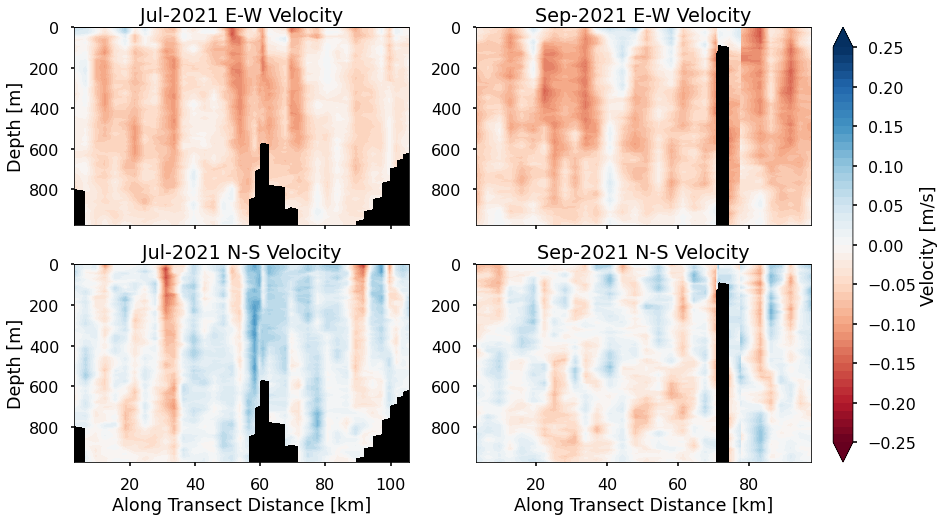

In [39]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(16,8))

axlist = [ax1,ax2,ax3,ax4]

color_levels = np.arange(-0.25,0.25+0.01,0.01)

first = ax1.contourf(cum_dist_a,subset_ds_a.depth,subset_ds_a.u_grid,cmap='RdBu',levels=color_levels,extend='both')
ax1.patch.set_facecolor('black')
ax1.set_title('Jul-2021 E-W Velocity')
ax1.xaxis.set_ticklabels([])
ax1.set_ylabel('Depth [m]')
ax1.set_ylim(975,0)

second = ax2.contourf(cum_dist_b,subset_ds_b.depth,subset_ds_b.u_grid,cmap='RdBu',levels=color_levels,extend='both')
ax2.patch.set_facecolor('black')
ax2.set_title('Sep-2021 E-W Velocity')
ax2.xaxis.set_ticklabels([])
ax2.set_ylim(975,0)

third = ax3.contourf(cum_dist_a,subset_ds_a.depth,subset_ds_a.v_grid,cmap='RdBu',levels=color_levels,extend='both')
ax3.patch.set_facecolor('black')
ax3.set_title('Jul-2021 N-S Velocity')
ax3.set_xlabel('Along Transect Distance [km]')
ax3.set_ylabel('Depth [m]')
ax3.set_ylim(975,0)

fourth = ax4.contourf(cum_dist_b,subset_ds_b.depth,subset_ds_b.v_grid,cmap='RdBu',levels=color_levels,extend='both')
ax4.patch.set_facecolor('black')
ax4.set_title('Sep-2021 N-S Velocity')
ax4.set_xlabel('Along Transect Distance [km]')
ax4.set_ylim(975,0)


cbar = fig.colorbar(first, ax=axlist,label='Velocity [m/s]',pad=0.025)
cbar.get_ticks()
cbar.set_ticks([-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25])

plt.savefig('/home/jg1200/Figures/RU29_2021_Mission_1_2_EW_NS.png',dpi=300,facecolor='white',bbox_inches='tight')


# Calculate geostrophic transport

In [95]:
segment_distances = np.empty(len(subset_ds.time))
segment_distances[:] = np.NaN

for x in np.arange(0,len(subset_ds.time)):
    segment_distances[x] = dist_from_lat_lon(subset_ds.start_lat[x],subset_ds.start_lon[x],subset_ds.end_lat[x],subset_ds.end_lon[x])
    

## Do on a finer vertical grid than the ADCP grid
geo_dz = 2
geo_griddepth = np.arange(0,1001,geo_dz)

## Pre-allocate
geogriddensity = np.empty((len(geo_griddepth),len(subset_ds.time)))
geogriddensity[:] = np.NaN


for x in np.arange(0,len(subset_ds.time)):
    sci_gdf2 = sci_gdf.loc[(sci_gdf.time.values >= subset_ds.start_time.values[x]) & (sci_gdf.time.values <= subset_ds.end_time.values[x])]
    geogriddensity[:,x]  = interp.griddata(sci_gdf2.depth.values,sci_gdf2.density.values,geo_griddepth)


## Pull out the DAC for each segment
subset_DAC_ds = np.empty(len(subset_ds.time.values))
subset_DAC_ds[:] = np.nan

for x in np.arange(0,len(subset_ds.time.values)):
    ## subset the glider dataframe that has the DAC
    mask = (pd.to_datetime(gdf['time'].values).tz_localize(None) >= subset_ds.start_time.values[x]) & (pd.to_datetime(gdf['time'].values).tz_localize(None) <= subset_ds.end_time.values[x])
    subset_gdf = gdf.loc[mask]

    ## pull out non-nan DACs
    notnanind = np.where(np.isnan(subset_gdf.m_water_vx.values) == False)[0]
    subset_DAC_ds[x] = np.nanmean(subset_gdf.m_water_vx.values[notnanind])
    

## Calculate $\frac{\partial \rho}{\partial y}$

Have to take d_rho with np.gradient and then can just divide that by the segment distances because that is the dy (change is distance from start to end of segment)


In [96]:
d_rho_dy = np.gradient(geogriddensity,axis=1)/segment_distances

/tmp/ipykernel_2766/1606328036.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(np.cumsum(segment_distances)/1000,geo_griddepth,geogriddensity)


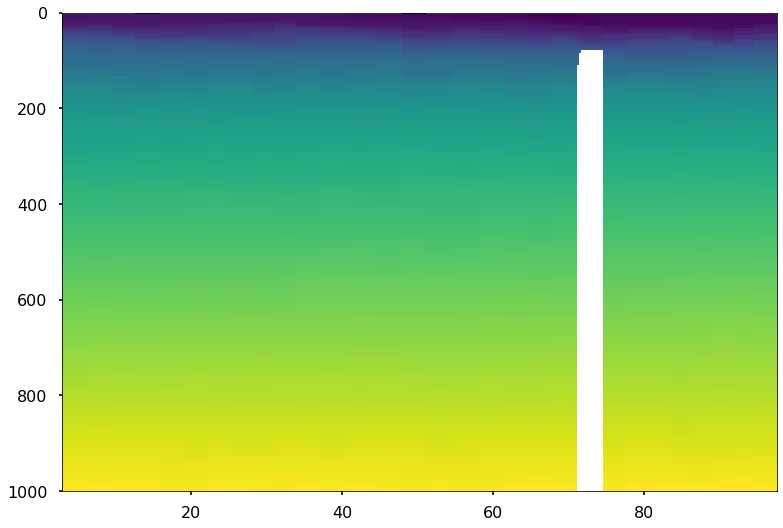

In [97]:
plt.pcolormesh(np.cumsum(segment_distances)/1000,geo_griddepth,geogriddensity)
plt.gca().invert_yaxis()

# So, because there that weird spot over dog knoll here, I am going to slice that out for all of the variables I am working with to make sure the derivatives don't get wonky

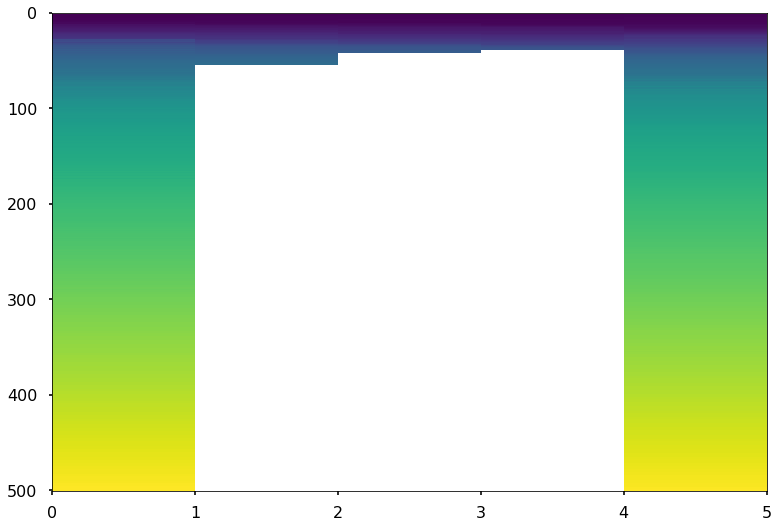

In [98]:
plt.pcolormesh(geogriddensity[:,21:26])
plt.gca().invert_yaxis()

In [101]:
geogriddensity = np.delete(geogriddensity, [22,23,24,25], axis=1)
segment_distances = np.delete(segment_distances,[22,23,24,25])
subset_DAC_ds = np.delete(subset_DAC_ds,[22,23,24,25])

/tmp/ipykernel_2766/1606328036.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(np.cumsum(segment_distances)/1000,geo_griddepth,geogriddensity)


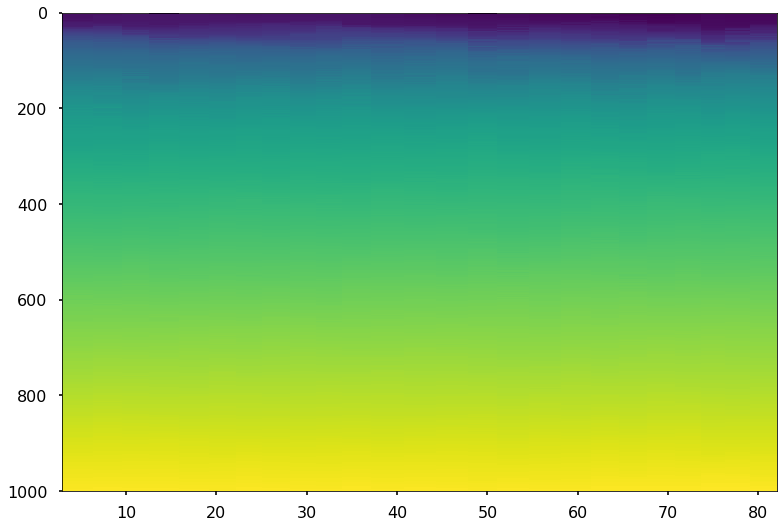

In [102]:
plt.pcolormesh(np.cumsum(segment_distances)/1000,geo_griddepth,geogriddensity)
plt.gca().invert_yaxis()

In [103]:
d_rho_dy = np.gradient(geogriddensity,axis=1)/segment_distances

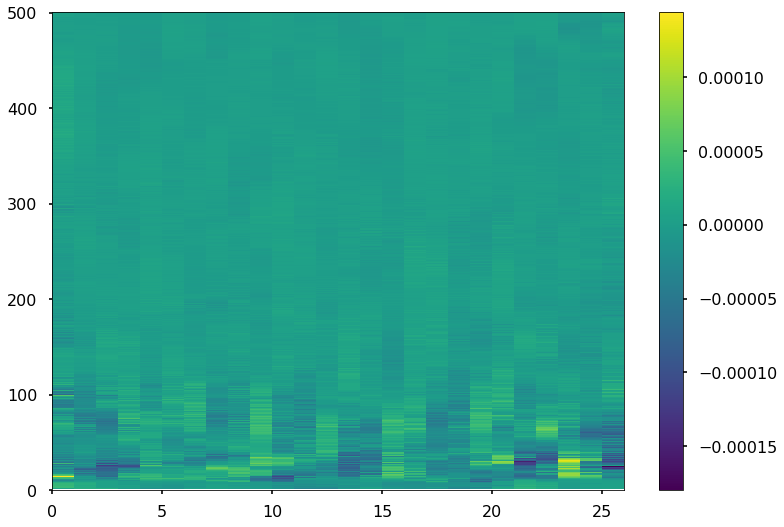

In [104]:
plt.pcolormesh(d_rho_dy,)
plt.colorbar()

# get $\frac{\partial u}{\partial z}$

ok, now we have all the components of the right hand side to give us how the velocity changes with depth :

$$
\frac{g}{\rho f}\frac{\partial \rho}{\partial y}
$$

In [105]:
import seawater as sw

CF = sw.extras.f(ds.start_lat.mean())

g = sw.eos80.g(ds.start_lat.mean(), 0)

therm_wind = (1/CF)*(g/1027)*d_rho_dy

# Integrate vertically to get $u$

So far we have $\frac{\partial u}{\partial z}$, or how velocity changes with depth. But what  we would really like to know is the total velocity $u$. 

We can integrate the shear to get this!

$$
u = \int \frac{du}{dz}dz
$$


or actually each little step in $v$ looks like this (just re arrainging the equation):

$$
\Delta u = \frac{\Delta u}{\Delta z} * \Delta z
$$

if you sub in the thermal wind equation it looks like this:

$$
\Delta u = \frac{-g}{\rho f}\frac{\Delta \rho}{\Delta y} * \Delta z
$$

and if we want the total $u$ we can sum up all the little $\Delta u$'s from the water column to get a profile of $u$

This actually just gives us a `relative geostrophic velocity` something we will have to reference to get the absolute velocity

In [106]:
from scipy import integrate

# replace nan with zeros for integration
therm_wind[np.where(np.isnan(therm_wind) ==True)] = 0

# flip to integrate from bottom, then flip back
rel_Vg = integrate.cumtrapz(therm_wind[::-1,:], dx=geo_dz, initial=0, axis=0)[::-1,:]


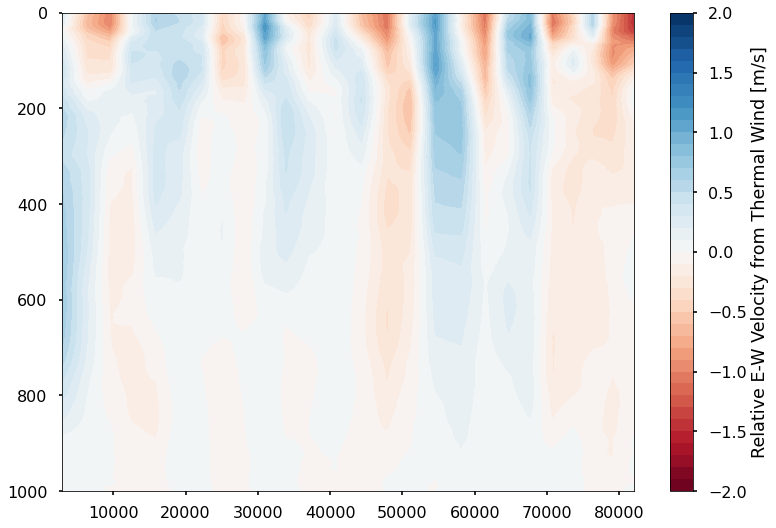

In [107]:
plt.contourf(np.cumsum(segment_distances),geo_griddepth,rel_Vg,cmap='RdBu',levels=np.arange(-2,2.01,0.1))
plt.colorbar(label='Relative E-W Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()

# add the reference velocity

$$
V_{abs}(x,z) = V_{rel}(x,z) + V_{ref}(x)
$$

The reference, $V_{ref}$, is calculated from the DAC ($V_{dac}$) such that:

$$
V_{ref}(x) = V_{dac} - \frac{1}{h}\int_h V_{g}(x,z)dz
$$

Text(0.5, 0, 'Along Track Distance [km]')

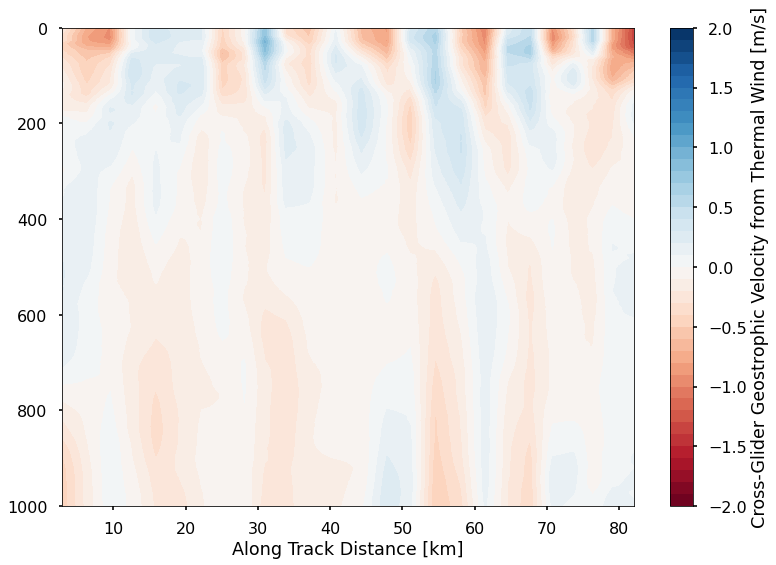

In [108]:
vref = subset_DAC_ds - np.nanmean(rel_Vg,axis=0)

Vgeo = rel_Vg + vref

plt.contourf(np.cumsum(segment_distances)/1000,geo_griddepth,Vgeo,cmap='RdBu',levels=np.arange(-2,2.01,0.1))
plt.colorbar(label='Cross-Glider Geostrophic Velocity from Thermal Wind [m/s]')
plt.gca().invert_yaxis()
plt.xlabel('Along Track Distance [km]')

## Put density on a finer grid than the ADCP data at first so now interpolate geostrophic velocity onto ADCP grid

In [109]:
Vgeo_interp = interp.griddata(geo_griddepth,Vgeo,griddepth, method='linear')
Vgeo_interp.shape

(102, 26)

## Calculate transport!

In [110]:
np.nansum(Vgeo_interp*dz*segment_distances)/(10**6)

-4.557211642717488